In [36]:
import matplotlib as mpl
from numpy.random import randint

import traceback
from matplotlib.pyplot import *
import matplotlib
import os
import bregnn.io as io
#import bregnn.utils as utils
import sys
import json
from optparse import OptionParser, make_option
sys.path.insert(0, '/users/nchernya/HHbbgg_ETH/bregression/python/')
import datetime
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import probfit
import iminuit
from scipy.stats import norm

from probfit import UnbinnedLH,Normalized,BinnedLH,crystalball
from probfit import gaussian
from iminuit import Minuit


In [47]:
def plot_response(input_dir,names,out_dir):
    for ind in ['smaller300']:
        matplotlib.rcParams['figure.figsize'] = [10, 10]
        fig1_no_Tail,ax1_no_Tail=plt.subplots()
        cycol = cycle('bgrcmk')


        fig3_no_Tail,ax3_no_Tail=plt.subplots()
        fig1_Tail,ax1_tail=plt.subplots()


        fig3_Tail,ax3_tail=plt.subplots()

        counter=0
        
        for i in range(0,len(input_dir)):
            
            if names[i].find("OneTail")>0:
                    end="HuberLossOneTail"
                    lbl="delta"+names[i][14]
                    fig1=fig1_Tail
                    ax1=ax1_tail
                    fig3=fig3_Tail
                    ax3=ax3_tail


            else:
                    end="HuberLoss"
                    lbl="delta"+names[i][14]
                    fig1=fig1_no_Tail
                    ax1=ax1_no_Tail
                    fig3=fig3_no_Tail
                    ax3=ax3_no_Tail

            inp_dir=input_dir[i]
            inp_file=names[i]

            data = io.read_data('%s%s'%(inp_dir,inp_file),columns=None)




            print("data read: ",end)
            y = (data['genPt']/data['pt']).values.reshape(-1,1)
            X_pt = (data['pt']).values.reshape(-1,1)
            X_eta = (data['scEta']).values.reshape(-1,1)
            response = (data['scRawEnergy']*data['response']).values.reshape(-1,1)
            response_NN = (data['scRawEnergy']*data['response_NN_'+end]).values.reshape(-1,1)
            gen_energy = (data['genEnergy']).values.reshape(-1,1)

            raw_energy = (data['scRawEnergy']).values.reshape(-1,1)
            raw=(data['scRawEnergy']/data['genEnergy']).values.reshape(-1,1)
            ax1.hist(response_NN,bins=100,label="response"+end+lbl+ind,range=(0,20000),density=True,histtype=u'step')
            if counter==0:
                ax1_no_Tail.hist(response,bins=100,label='BDT',range=(0,20000),density=True,histtype=u'step')
                ax3_no_Tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
                ax3_no_Tail.hist(gen_energy/response,bins=1000,range=(0.8,1.2),log=False,label='BDT',histtype=u'step');
                ax1_tail.hist(response,bins=100,label='BDT',range=(0,20000),density=True,histtype=u'step')
                ax3_tail.hist(raw,bins=1000,label='raw',range=(0.8,1.2),histtype=u'step')
                ax3_tail.hist(gen_energy/response,bins=1000,range=(0.8,1.2),log=False,label='BDT',histtype=u'step');
                counter+=1


            ax3.hist(gen_energy/response_NN,bins=1000,range=(0.8,1.2),
                     log=False,label='corrected_'+end+lbl+ind,histtype=u'step');



        ax3_no_Tail.legend(loc='upper right');
        ax1_no_Tail.legend(loc='upper right')
        ax1_no_Tail.set_title("histogramm scRawEnergy*response  Huber pt {}".format(ind))
        ax3_no_Tail.set_title("Histogram gen_energy/response Huber pt {}".format(ind))
        fig1_no_Tail.show()
        fig3_no_Tail.show()
        fig3_no_Tail.savefig("{}/historical_comparision{}".format(out_dir,ind))
        fig1_no_Tail.savefig("{}/response{}".format(out_dir,ind))
        ax3_tail.legend(loc='upper right');
        ax1_tail.legend(loc='upper right')
        ax1_tail.set_title("histogramm scRawEnergy*response  HuberOneTail pt {}".format(ind))
        ax3_tail.set_title("Histogram gen_energy/response HuberOneTail pt {}".format(ind))
        fig1_Tail.show()
        fig3_Tail.show()
       # fig3_Tail.savefig("{}/historical_comparisionOneTailpt{}".format(out_dir,ind))
        #fig1_Tail.savefig("{}/responseOneTailpt{}".format(out_dir,ind))


applied_res_2019-04-25_Ntup_10Nov_Photon_training_allvars.hd5
('data read: ', 'HuberLoss')


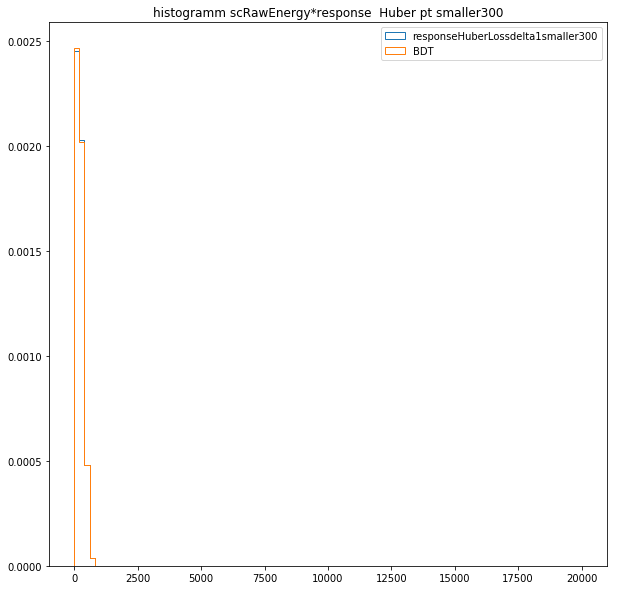

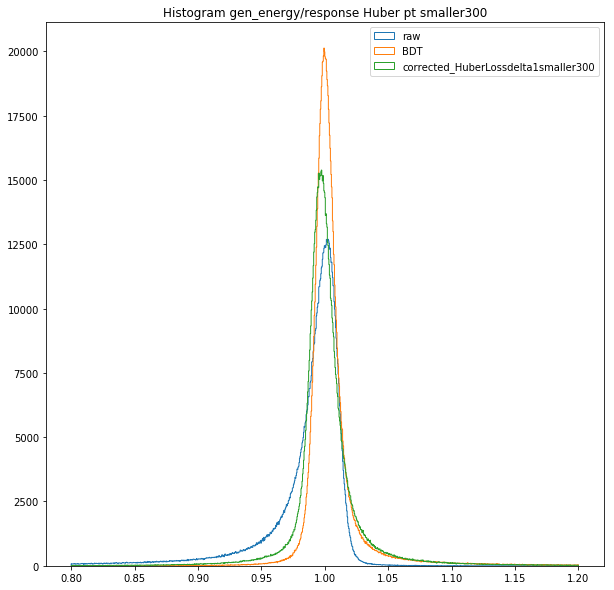

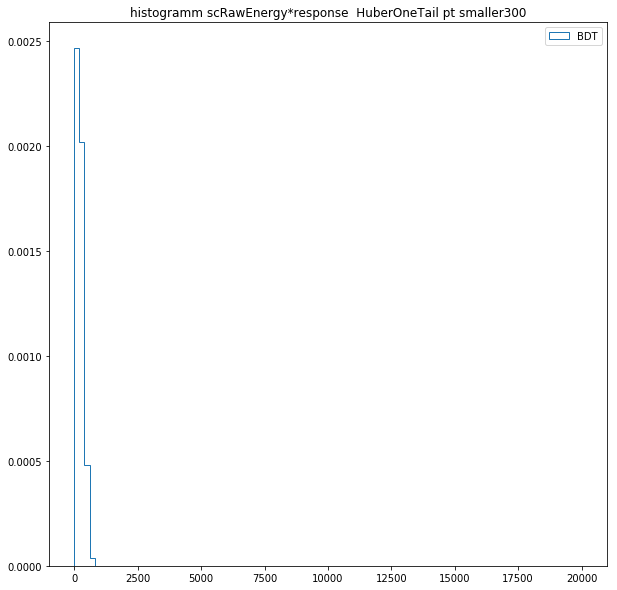

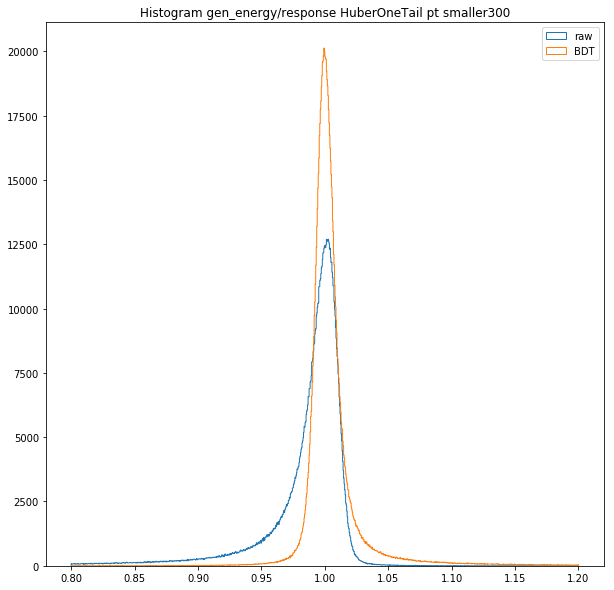

In [51]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
from probfit.pdf import doublecrystalball,doublegaussian
from probfit.plotting import draw_normed_pdf
from itertools import cycle
InteractiveShell.ast_node_interactivity = "last_expr"
input_dir=[]
names=[]
parent_dir="/t3home/kaechb/HuberLossApply2/"
for dire in [parent_dir]:
      
        if dire=="ntuples_NN":
            continue
    #if  os.path.isdir("/work/kaechb/"+dire):
        for file in os.listdir(parent_dir):#+"/"+dire
            print(file)
        #for file in os.listdir(sys.argv[1]):
            if file.find('.hd')!=-1 and file.find('applied')!=-1:
                
                input_dir.append(parent_dir)#+dire+"/"][0]
                names.append(file)

plot_response(input_dir,names,"/t3home/kaechb/HuberLossApply2")
inp_dir=input_dir
out_dir="/t3home/kaechb/HuberLossApply2"
end="applied_"

In [17]:
names

['applied_res_2019-04-21_Ntup_10Nov_Photon_training_allvars.hd5']

/t3home/kaechb/HuberLossApply2/applied_res_2019-04-25_Ntup_10Nov_Photon_training_allvars.hd5
max n:29.8658268966 at 0.974526520967


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 5649c051d340>
  0.974961499906
  0.00864085461419
  0.0115354727741

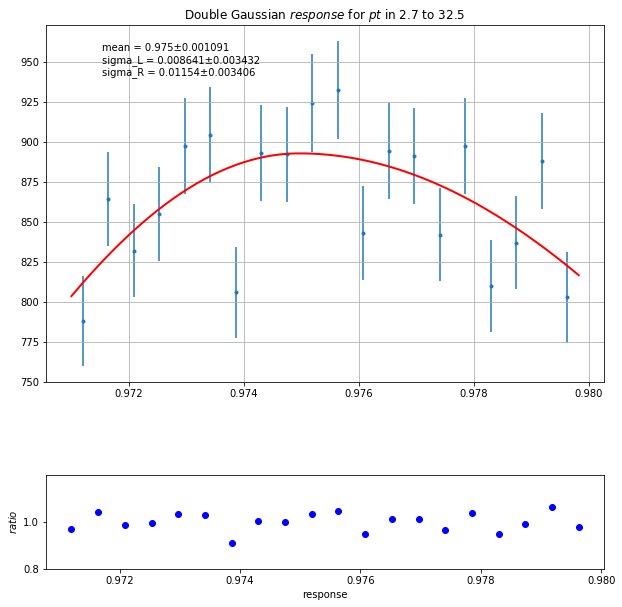

max n:46.1247712843 at 0.988281771541


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 5649bf05ea80>
  0.990138162859
  0.00934536302025
  0.0025277661308

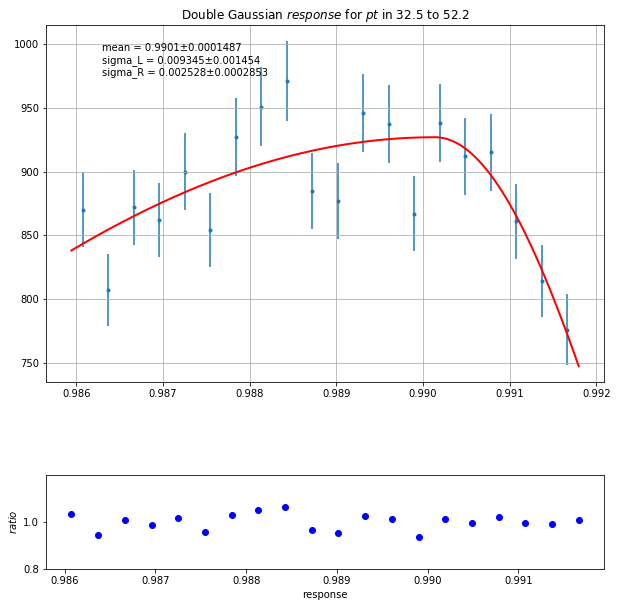

max n:61.2072338849 at 0.993006801605


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9930068016052246, -0.010465751733231443)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bfdb66b0>
  0.994302788064
  0.00567278374115
  0.00374877001417

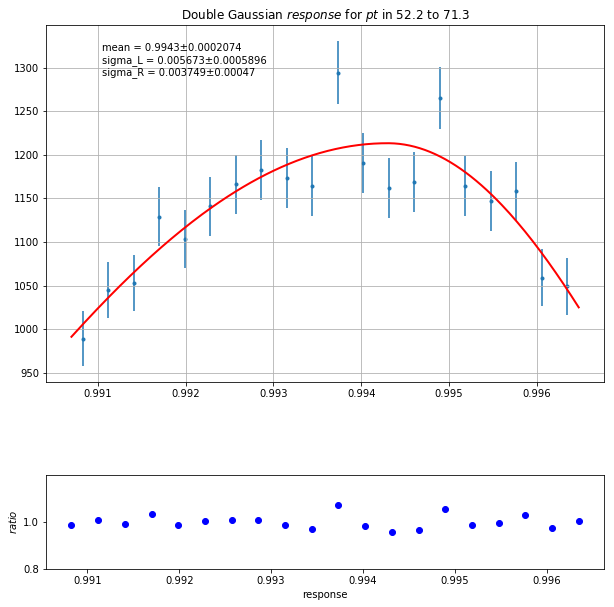

max n:75.5912301132 at 0.995608789921


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9956087899208069, -0.05467924142990627)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649c0067330>
  0.997086636857
  0.00435311108236
  0.00318156616707

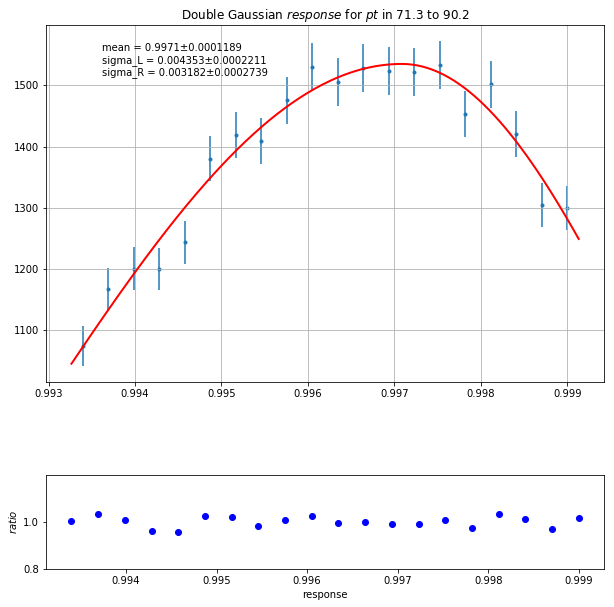

max n:88.4603768485 at 0.997646024823


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9976460248231888, -0.013506253214736905)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c07a7d00>
  0.998893059741
  0.00438085806759
  0.00231529692423

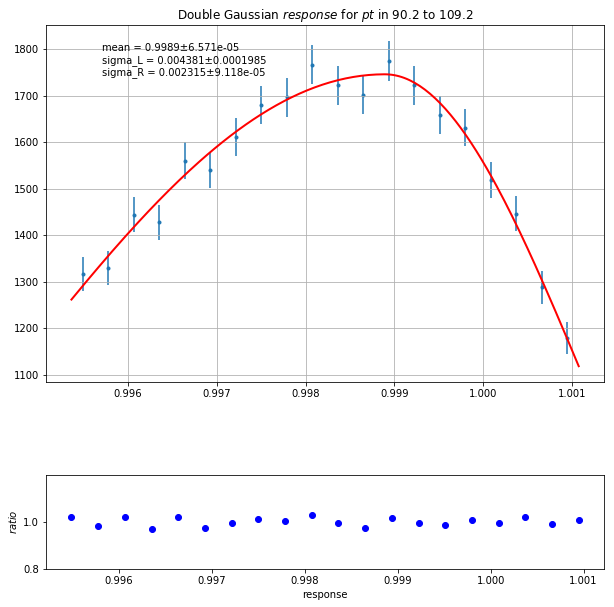

max n:95.2013046519 at 0.998949367404


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9989493674039841, -0.01712394523150937)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649c0aab5b0>
  0.999711437912
  0.00424994216161
  0.00223802269968

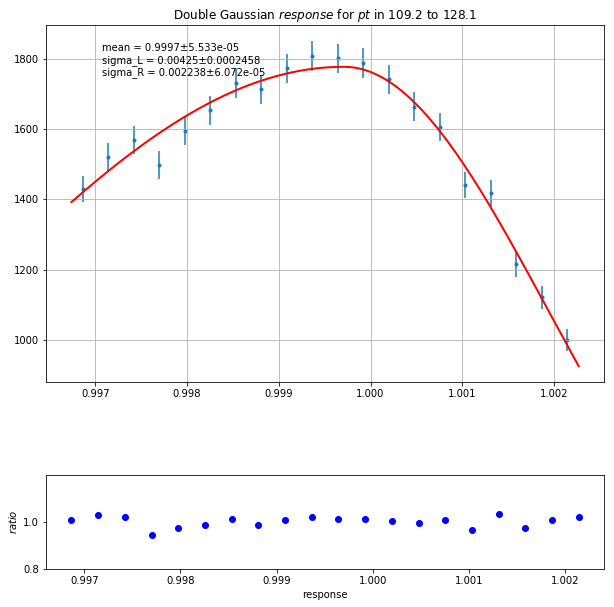

max n:96.8396684107 at 0.999309659004


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9993096590042114, -0.012170749041547607)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649be001260>
  0.999965018609
  0.00359977019052
  0.00283008258557

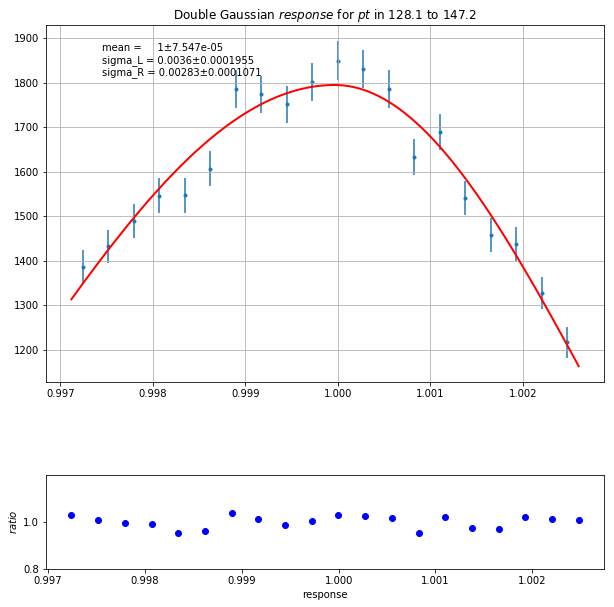

max n:93.0565166004 at 1.0004728359


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0004728358983994, -0.016967198180256743)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bdf33370>
  1.00063423972
  0.00462602406238
  0.00288468445641

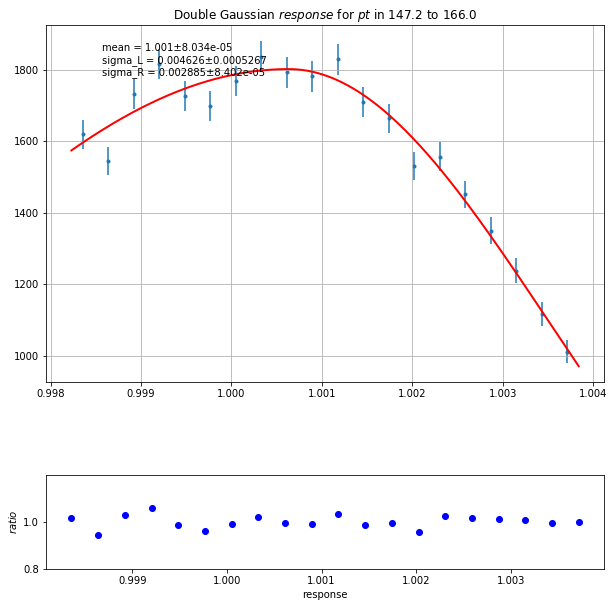

max n:96.4797127841 at 1.00005786419


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.000057864189148, -0.018085815303450214)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649be5d19c0>
  1.0006074394
  0.00323776320736
  0.003906377282

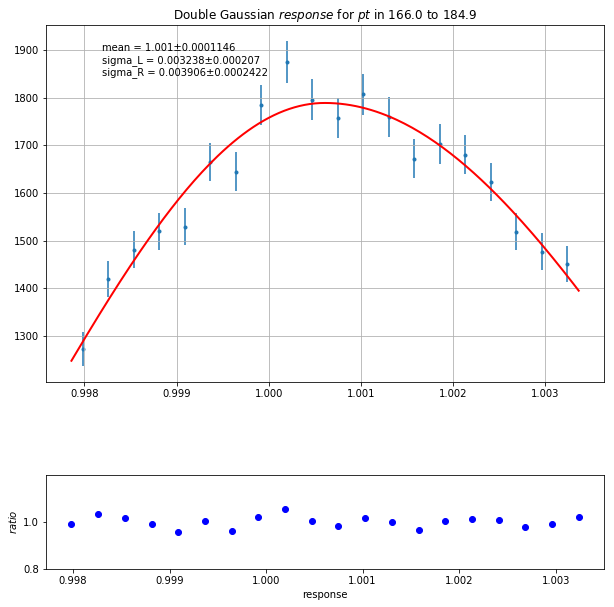

max n:101.560309782 at 1.00086129904


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0008612990379333, -0.011229131945201344)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bed26d20>
  1.00096874137
  0.00305525046733
  0.00331856595254

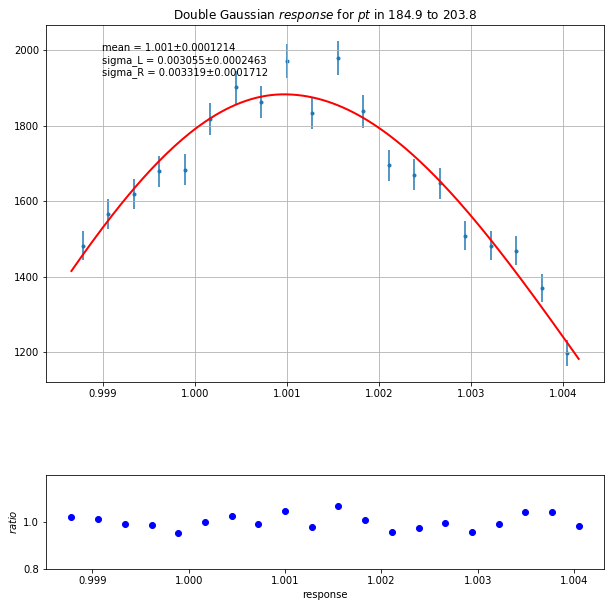

max n:101.263902386 at 1.00055433691


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0005543369054795, -0.021010170681159207)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf8293a0>
  1.00134034249
  0.00336350405648
  0.00314266095182

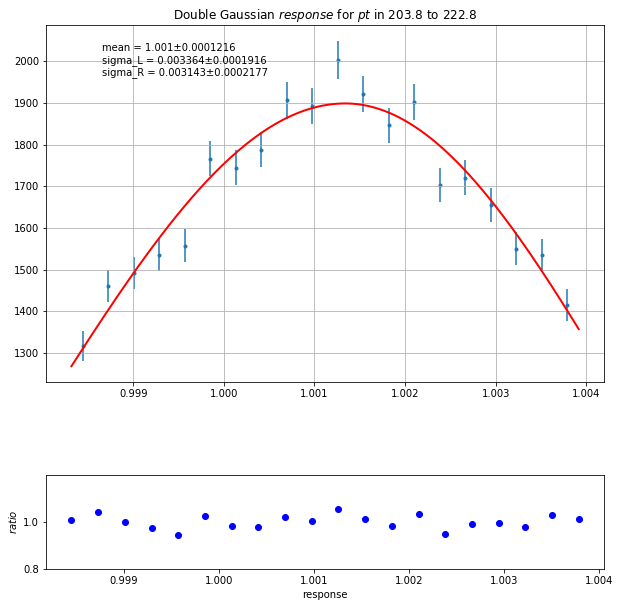

max n:98.9745387497 at 1.00163940132


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0016394013166428, -0.028661720694700923)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649beda29f0>
  1.00189673519
  0.00354309082444
  0.00229898126541

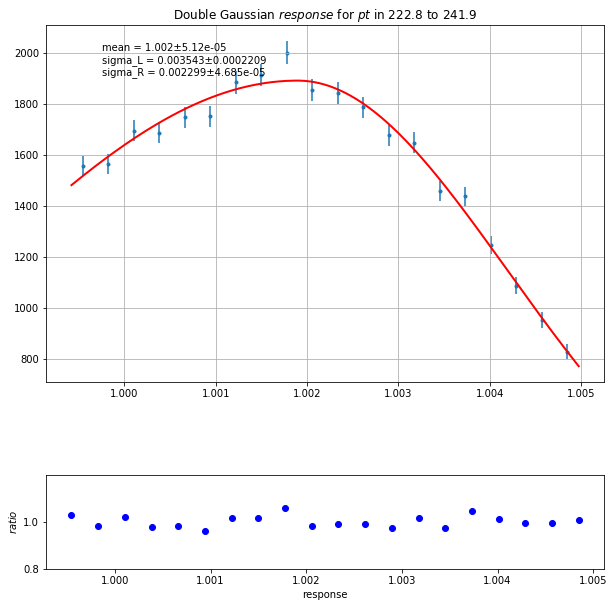

max n:97.8047837257 at 1.00123176575


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0012317657470704, -0.015283534426504208)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c11d12e0>
  1.00247279189
  0.00498784846964
  0.00169691595896

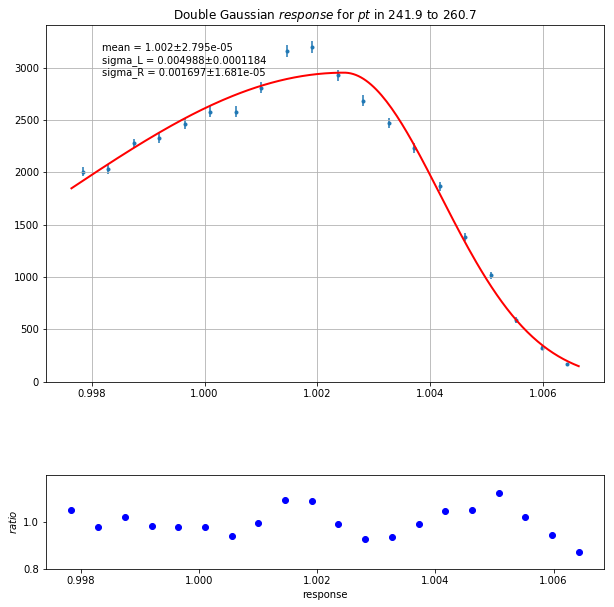

max n:92.904586513 at 1.00070280373


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0007028037309647, -0.022190066394915026)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649beacb550>
  1.00205363838
  0.00427677310074
  0.00197911008153

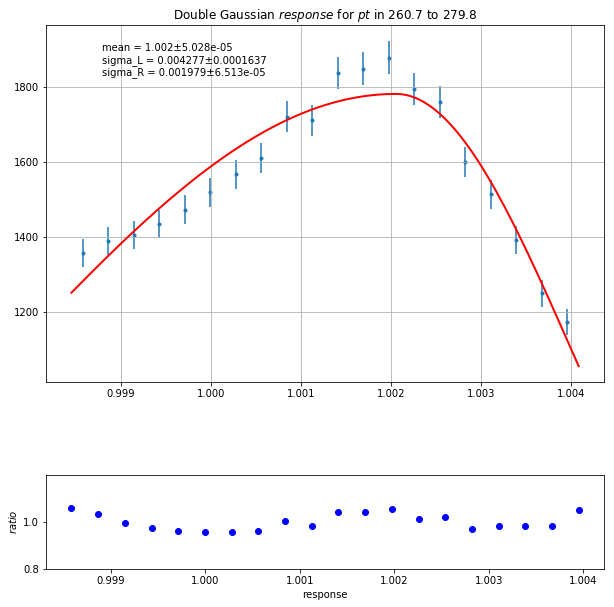

max n:87.9485976527 at 1.00102594852


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.001025948524475, -0.01616671382084904)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: Ini

<ArgsView of Minuit at 5649c0068170>
  1.00216145043
  0.00491640179695
  0.00200339964402

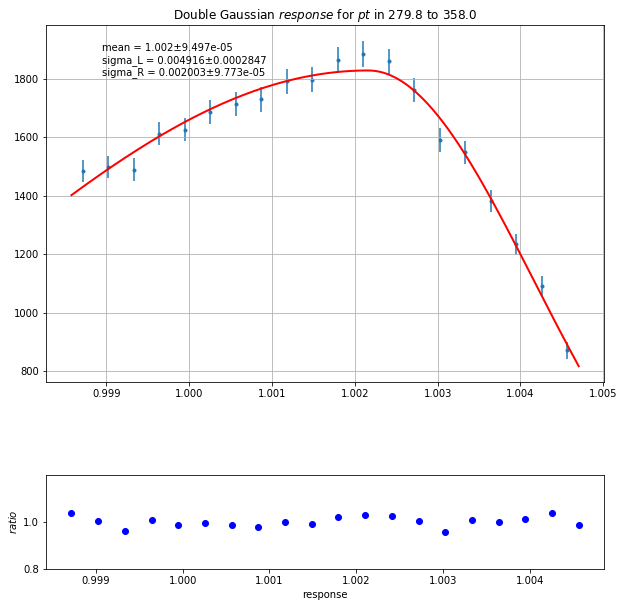

/t3home/kaechb/HuberLossApply2/applied_res_2019-04-25_Ntup_10Nov_Photon_training_allvars.hd5
max n:51.6572167764 at 0.99567647934


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9956764793395996, -0.005511517573078238)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf1373c0>
  0.995908635231
  0.00351531267081
  0.00496664611941

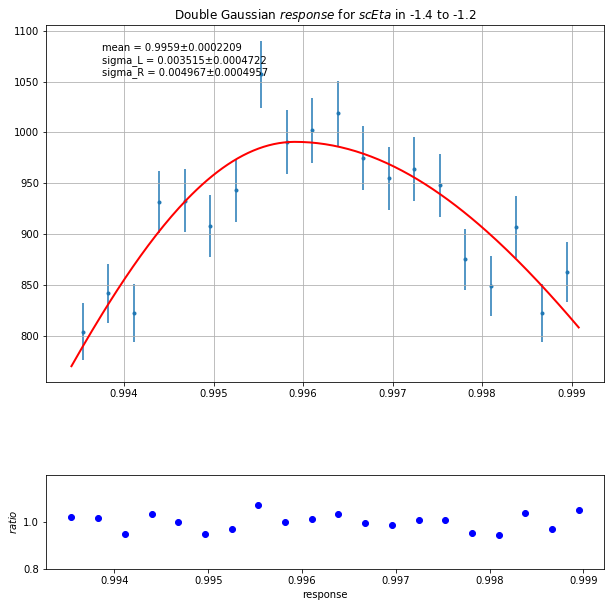

max n:61.7518662802 at 0.998561859131


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9985618591308594, -0.0028146857413416312)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: 

<ArgsView of Minuit at 5649bf466fb0>
  0.999205361526
  0.00598395228716
  0.00310605658099

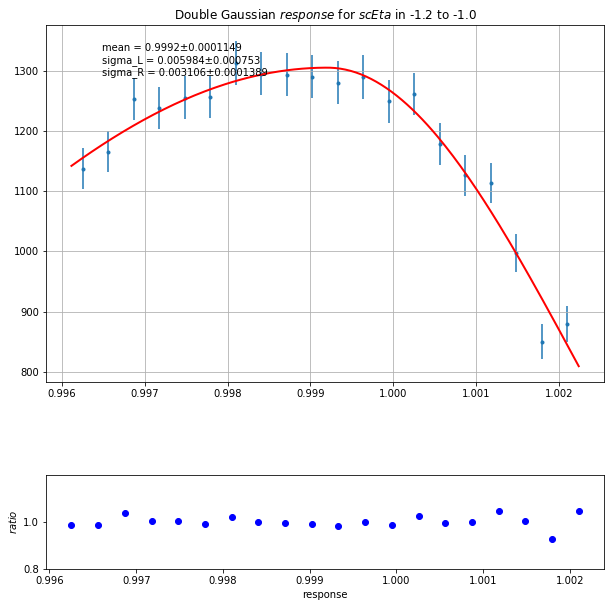

max n:84.1012589591 at 1.00058210492


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.000582104921341, -0.022414565499717362)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649bfd85f20>
  1.00140566569
  0.00406827875513
  0.0020264998774

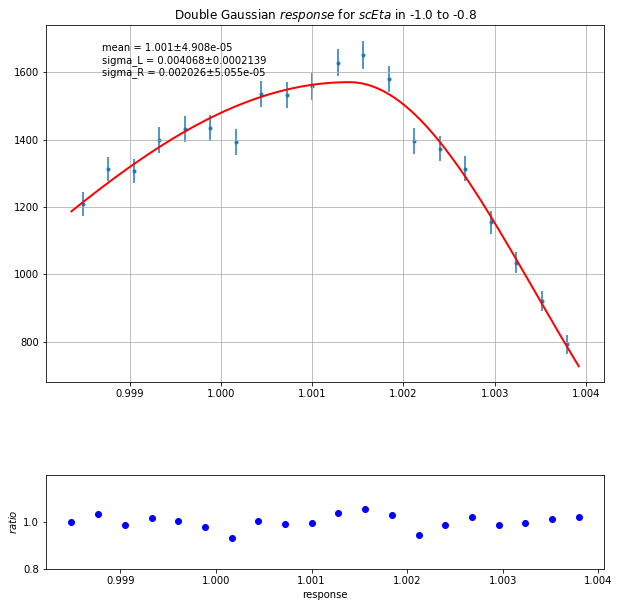

max n:77.2896321412 at 1.00100222409


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0010022240877152, -0.022439411749052895)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf7c8f00>
  1.00166638259
  0.00904837231523
  0.00223039469642

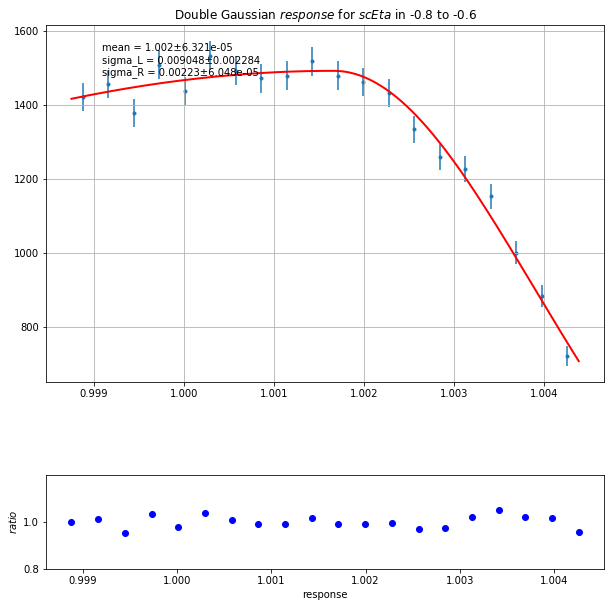

max n:78.6138100233 at 1.00130276024


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.001302760243416, -0.0148813131639728)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: Init

<ArgsView of Minuit at 5649bf8db300>
  1.00185488851
  0.00705796767339
  0.00260360756904

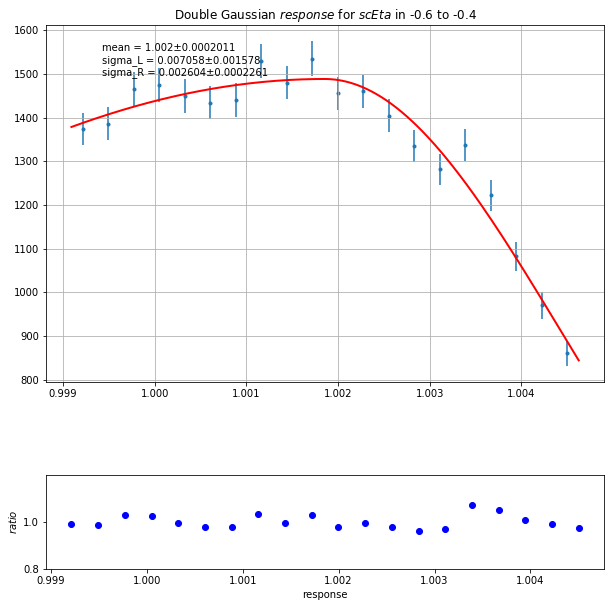

max n:77.5230362941 at 0.999344673157


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9993446731567383, -0.020190477663259723)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c218df00>
  1.00052143011
  0.00430211512011
  0.00300971115103

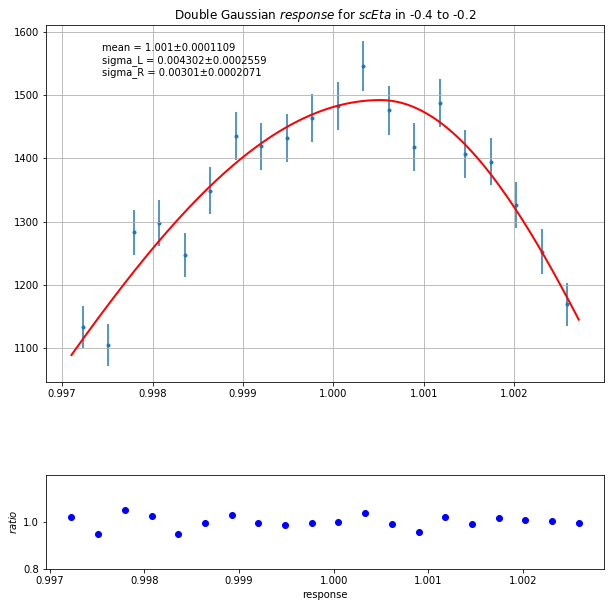

max n:80.3512769995 at 0.999567294121


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9995672941207886, -0.024962078447186883)
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probfit._libstat.xlogyx' ignored
Exception ZeroDivisionError: 'float division' in 'probf

<ArgsView of Minuit at 5649bece24b0>
  1.0007079497
  0.00413312276426
  0.00308054394012

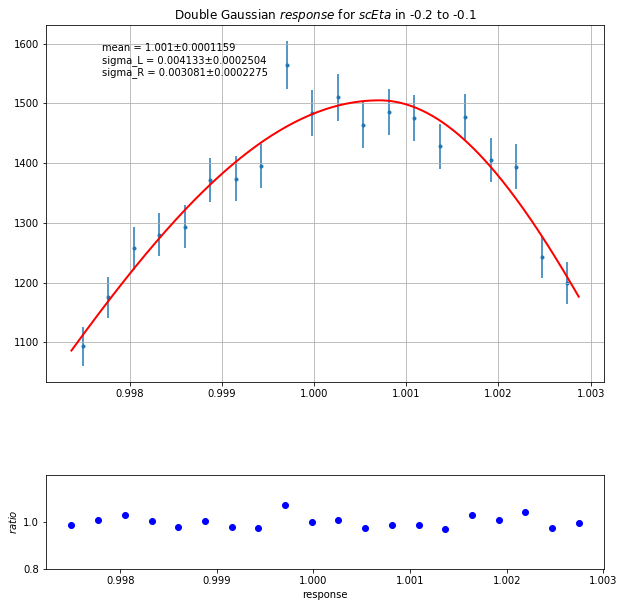

max n:72.9010222144 at 0.999405779839


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.999405779838562, -0.0252181915948307)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: Init

<ArgsView of Minuit at 5649c08a2ca0>
  1.00045414587
  0.00449594501697
  0.00325852811378

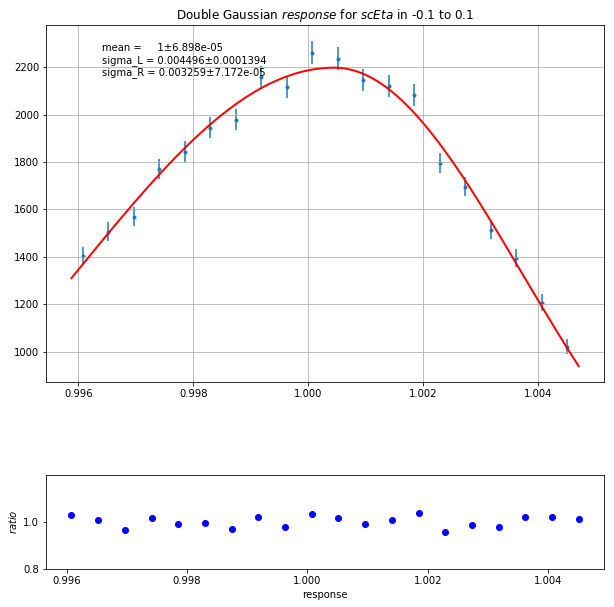

max n:78.4622837913 at 1.00006498098


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.000064980983734, -0.005568749488717564)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649bda5f9d0>
  1.00069821405
  0.00393551996068
  0.00348346194856

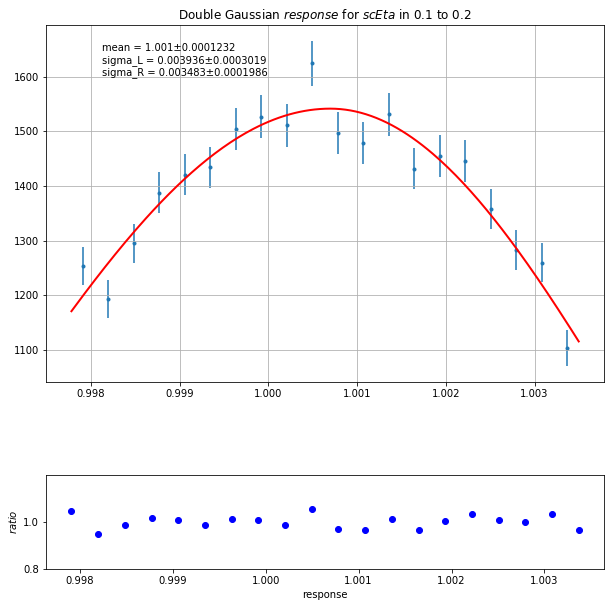

max n:76.699675837 at 0.99994464159


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9999446415901184, -0.009391838795681881)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bfae4490>
  1.00104100542
  0.00449854589885
  0.00273097669977

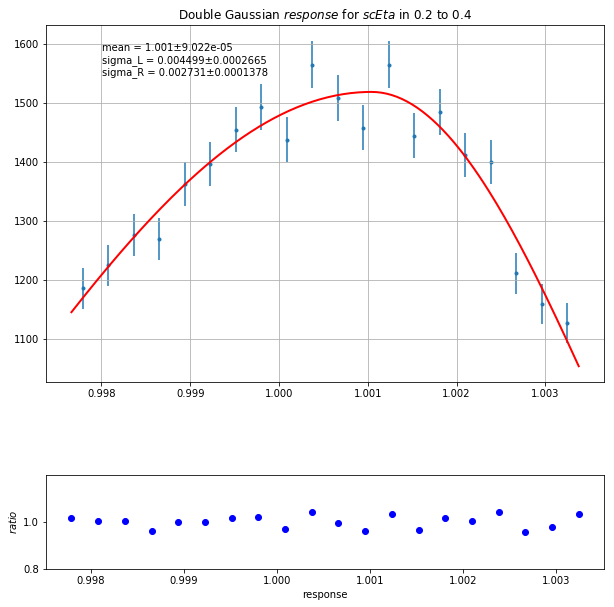

max n:78.0665583997 at 0.99945204258


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9994520425796509, -0.02126614995452089)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649bfb79770>
  1.00149020126
  0.00514364872161
  0.00291740829532

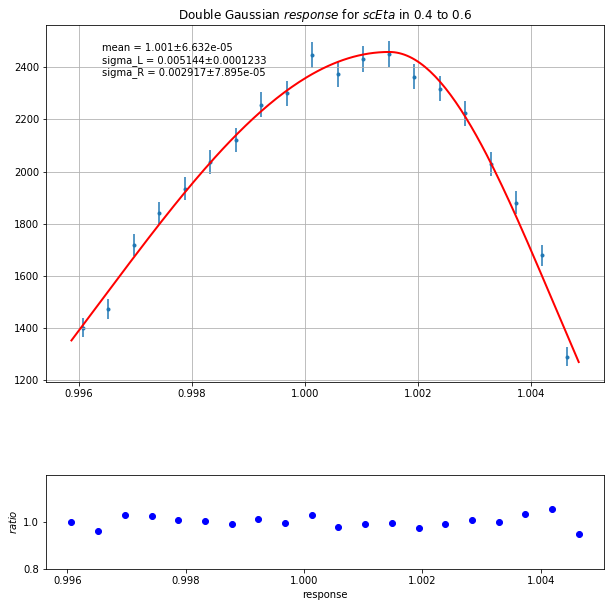

max n:79.0683963456 at 1.00074288845


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0007428884506226, -0.013518948716144855)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf529300>
  1.00138580003
  0.00499578993435
  0.00249136696732

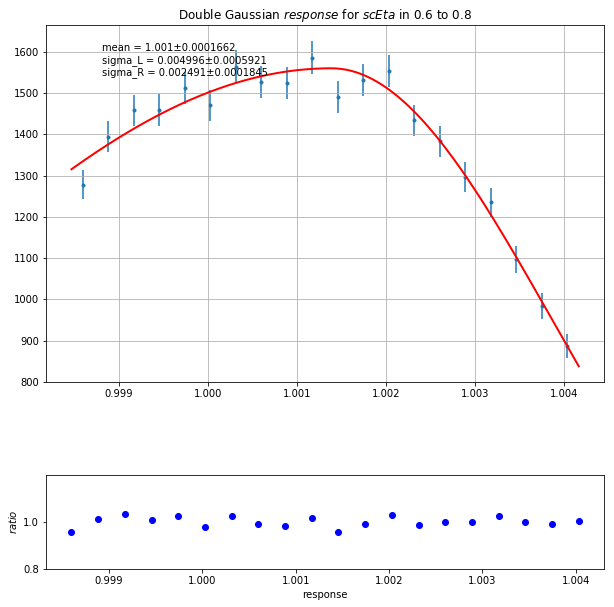

max n:83.0698311893 at 1.00005377531


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0000537753105163, -0.012333575111985358)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bfb24110>
  1.00097685563
  0.00431856739928
  0.00239974264203

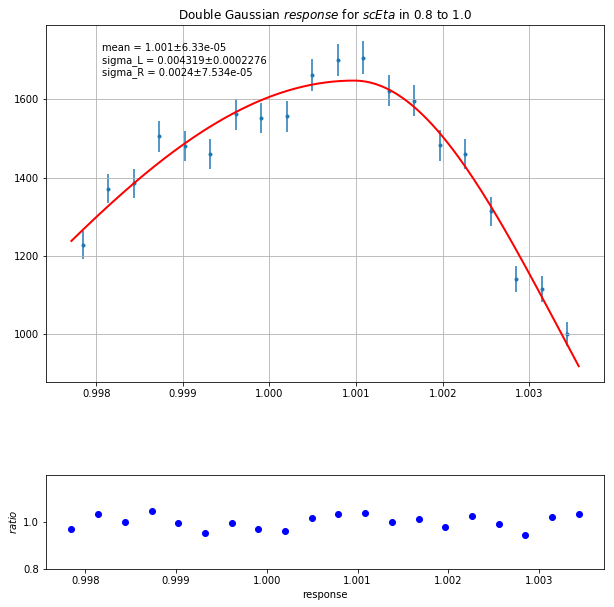

max n:65.2702110028 at 0.997956348658


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9979563486576081, -0.005861621403815666)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649be596940>
  0.998932936308
  0.00440999812878
  0.0033088897081

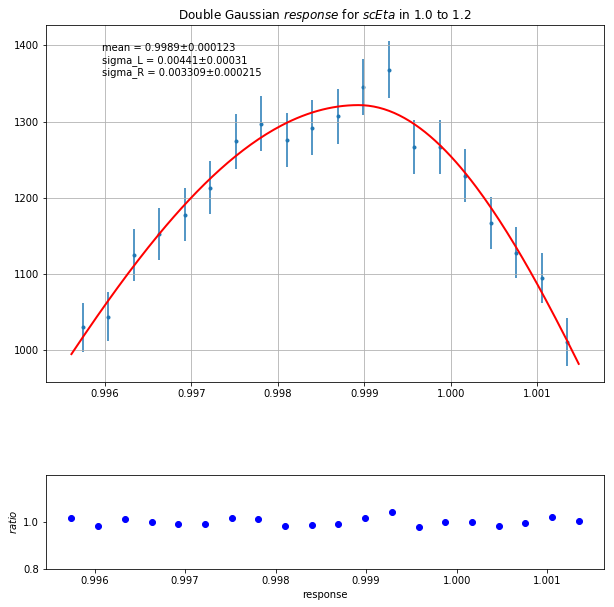

max n:54.9649903979 at 0.995332932472


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.995332932472229, -0.031280279467759076)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649c3514780>
  0.996676832856
  0.00442567665623
  0.00298765443849

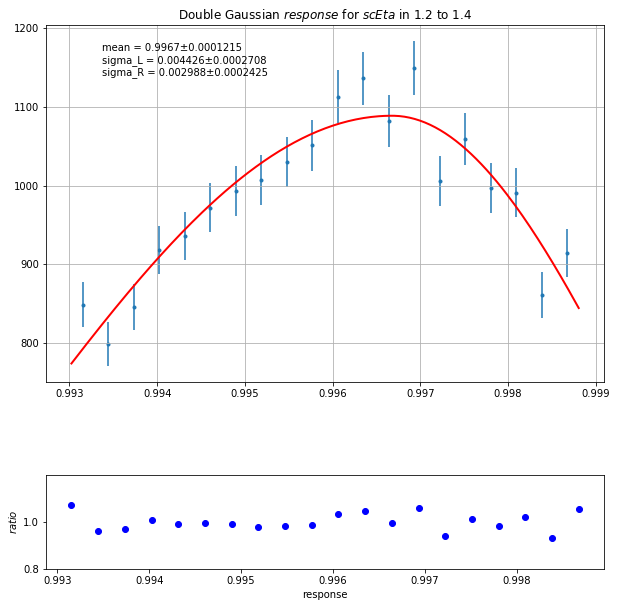

/t3home/kaechb/HuberLossApply2/applied_res_2019-04-25_Ntup_10Nov_Photon_training_allvars.hd5
max n:67.2019380206 at 0.998946436644


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9989464366436005, -0.056012016403824694)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c11c1af0>
  1.00013169175
  0.00446983007928
  0.0041491725369

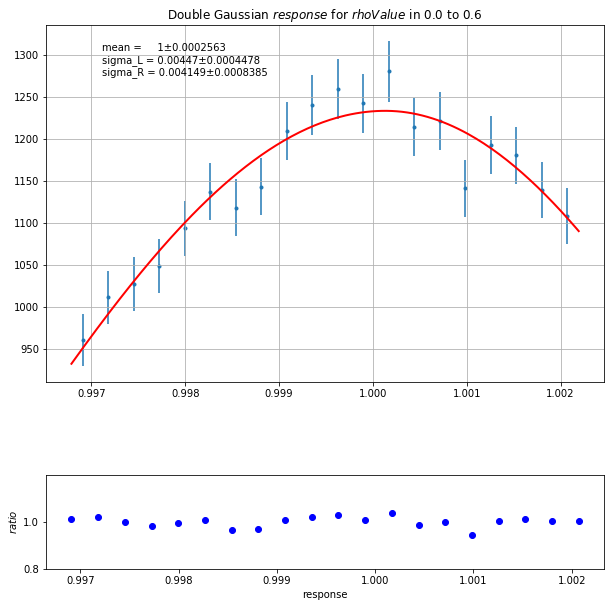

max n:68.4859627309 at 0.999610913396


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9996109133958817, -0.013646863259089842)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bde2fa00>
  1.00109067869
  0.00529591748928
  0.00183220304972

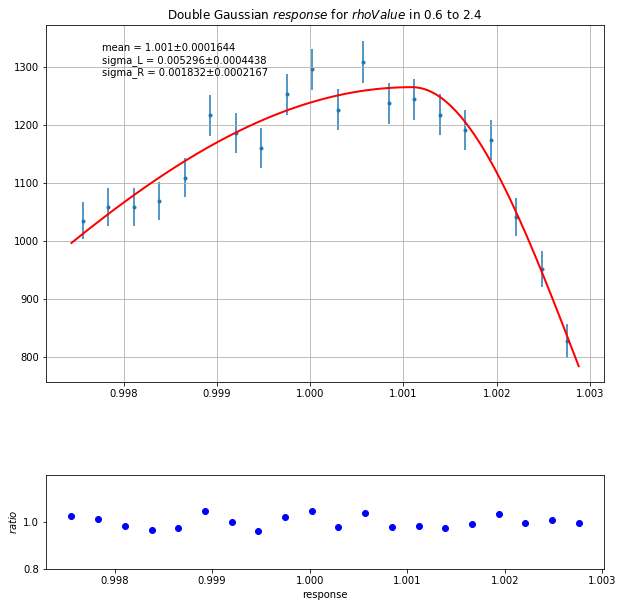

max n:66.5650713169 at 0.999477864504


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9994778645038604, -0.009367537168420786)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649be1b2890>
  1.00092068498
  0.00549183571192
  0.0021219662466

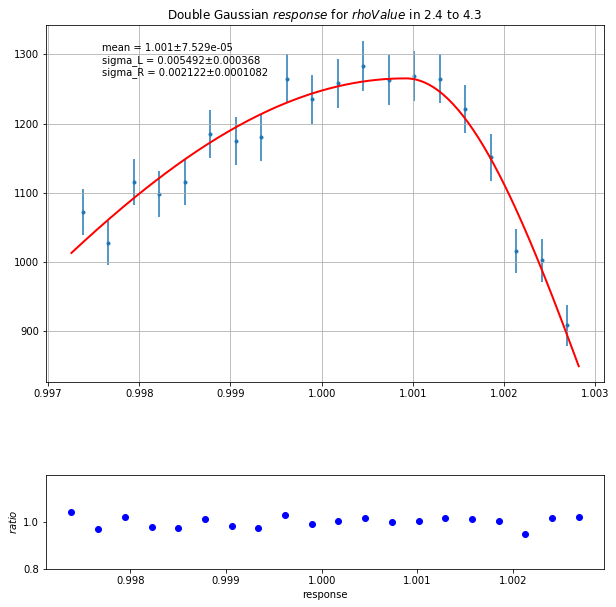

max n:66.3450647443 at 1.00077518821


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0007751882076263, -0.028127928902195384)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c027ba90>
  1.00090732405
  0.00536574743145
  0.00253174573104

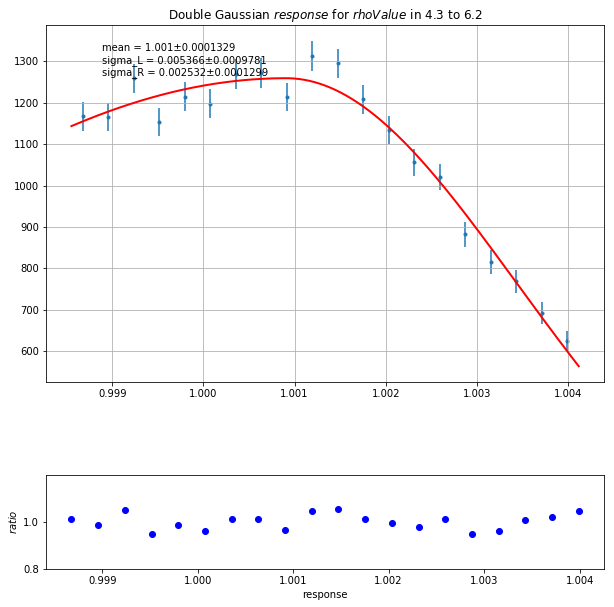

max n:67.0219486893 at 1.0005121392


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0005121392011642, -0.017569269985231506)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c2800880>
  1.00071691298
  0.00549982880038
  0.00282531090966

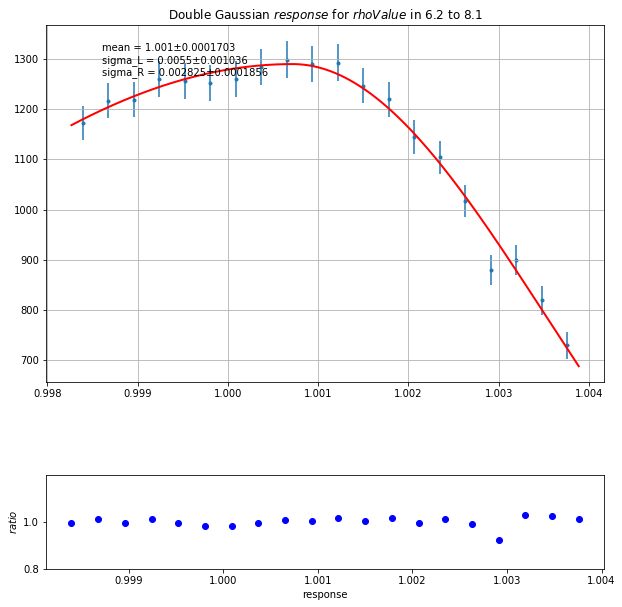

max n:66.0196563802 at 0.998885066509


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.021819628240116, -0.07393050892599687)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: Ini

<ArgsView of Minuit at 5649c04e8f40>
  0.99939974616
  0.00490823508505
  0.015619706871

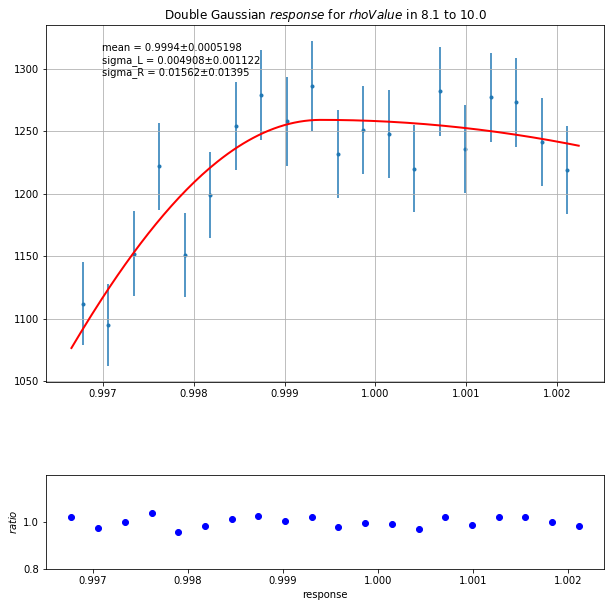

max n:68.237777976 at 1.0003276825


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0003276824951173, -0.012370765757459434)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c3489800>
  1.0005869709
  0.00663576851872
  0.00303372230806

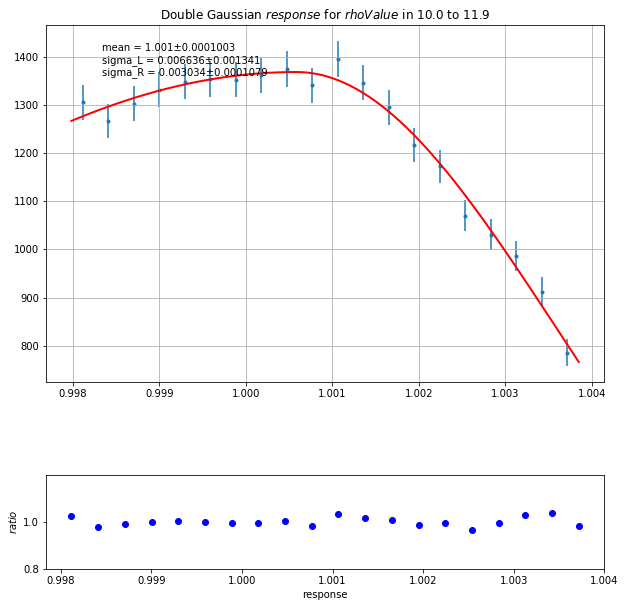

max n:68.7578243916 at 0.998397794962


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9983977949619294, -0.0006832688617547239)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: 

<ArgsView of Minuit at 5649c3508250>
  0.999267545256
  0.00390540991021
  0.00837058256445

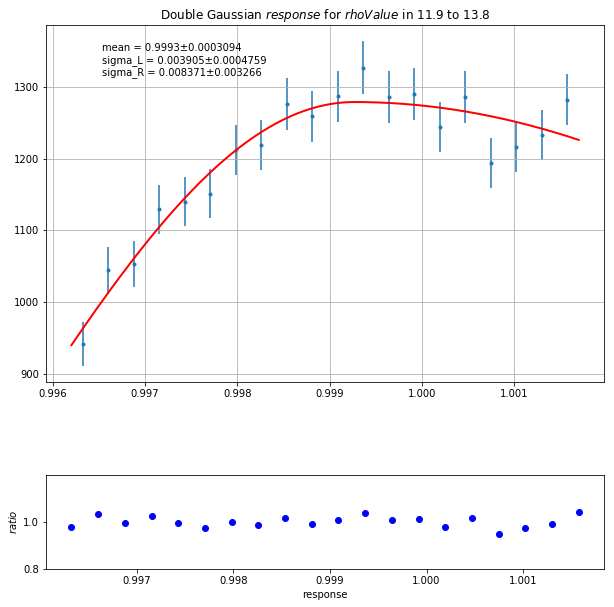

max n:69.4385793199 at 0.998371328115


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9983713281154633, -0.013035478501381231)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649c0b2da20>
  0.999395679392
  0.00386896585149
  0.00659500763475

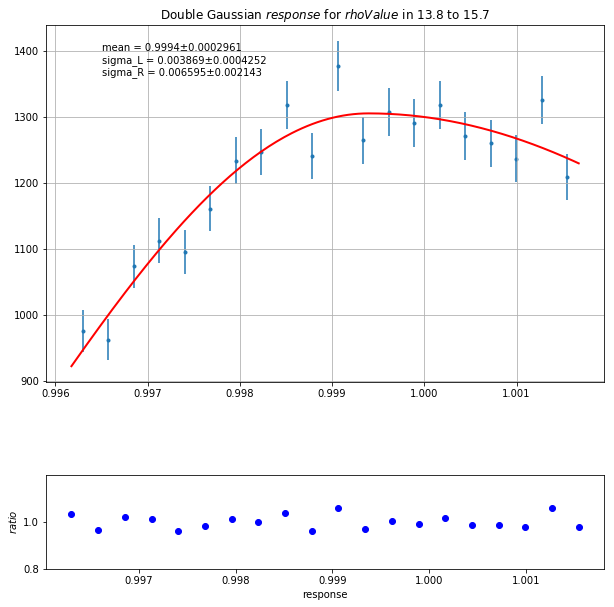

max n:72.5799302239 at 0.998582851291


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_R is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-pack

<ArgsView of Minuit at 5649c079c6c0>
  0.999555844072
  0.00358279961412
  0.00473236225283

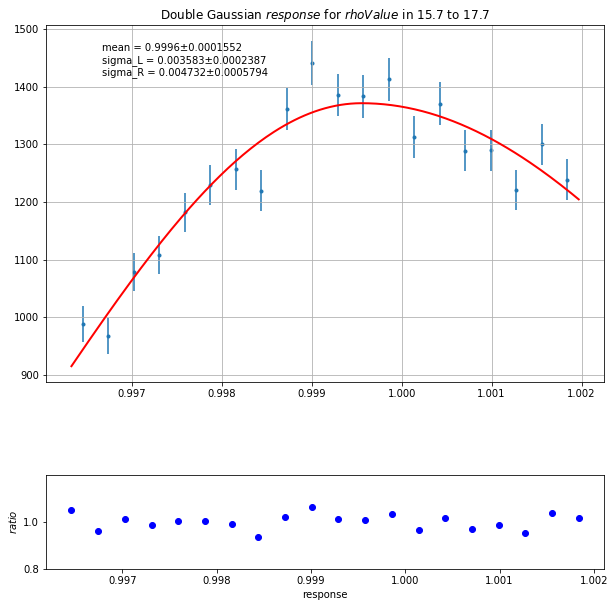

max n:72.7802053928 at 0.998909102678


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9989091026782989, -0.018540700512433686)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf42a190>
  0.999657412303
  0.00379072586708
  0.00425920792076

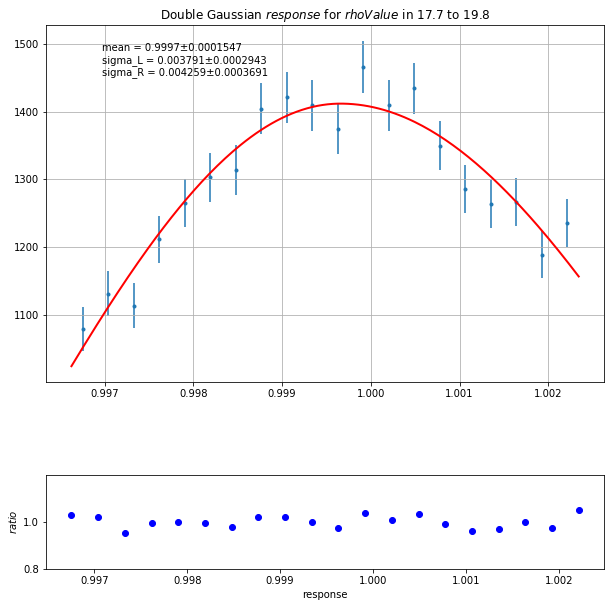

max n:74.5303410531 at 0.999947888255


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9999478882551194, -0.00336306671852607)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649bff84a30>
  1.00015553407
  0.00391211629706
  0.00369552441405

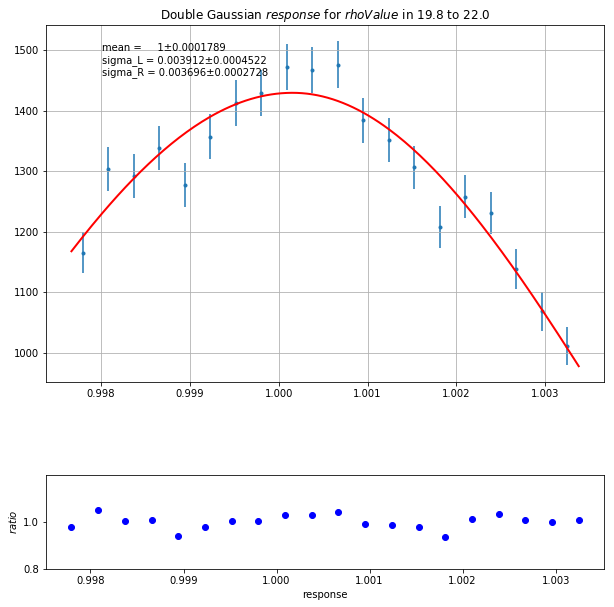

max n:75.2038168716 at 1.00013334751


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (1.0001333475112915, -0.005341324053409667)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bf452920>
  1.00029757399
  0.00455382158428
  0.00350627200924

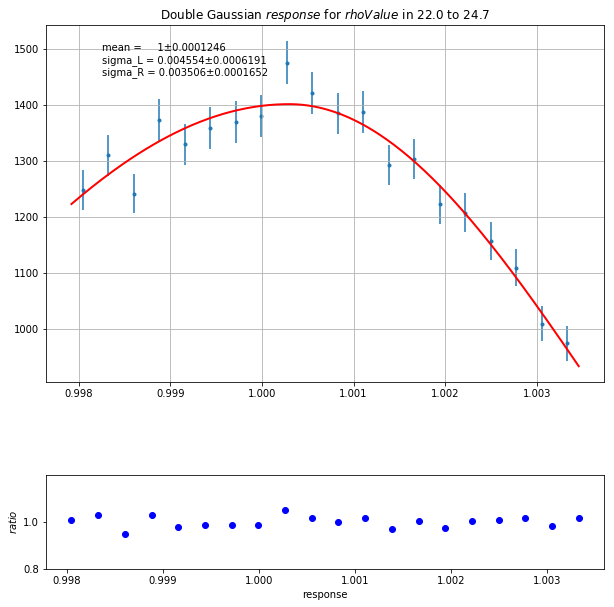

max n:75.0874930575 at 0.999575562477


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9995755624771119, -0.017576167903844184)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: I

<ArgsView of Minuit at 5649bff919d0>
  1.00044367076
  0.00375967556967
  0.00344948419187

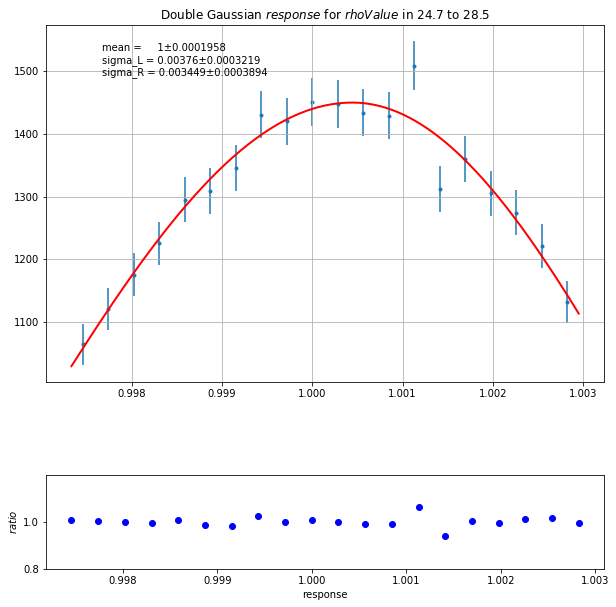

max n:73.9592536001 at 0.99942009747


/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:92: InitialParamWarning: Parameter sigma is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: SmallIntegralWarning: (0.9994200974702835, -0.02119327013993967)
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter mean is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: InitialParamWarning: Parameter sigma_L is floating but does not have initial step size. Assume 1.
/work/mdonega/anaconda3/envs/python2/lib/python2.7/site-packages/ipykernel_launcher.py:113: In

<ArgsView of Minuit at 5649bf480ed0>
  1.00150198561
  0.0054318266425
  0.00264716658617

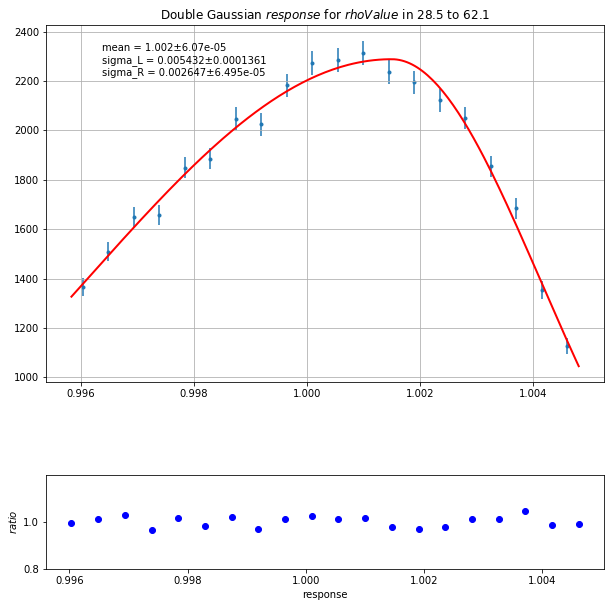

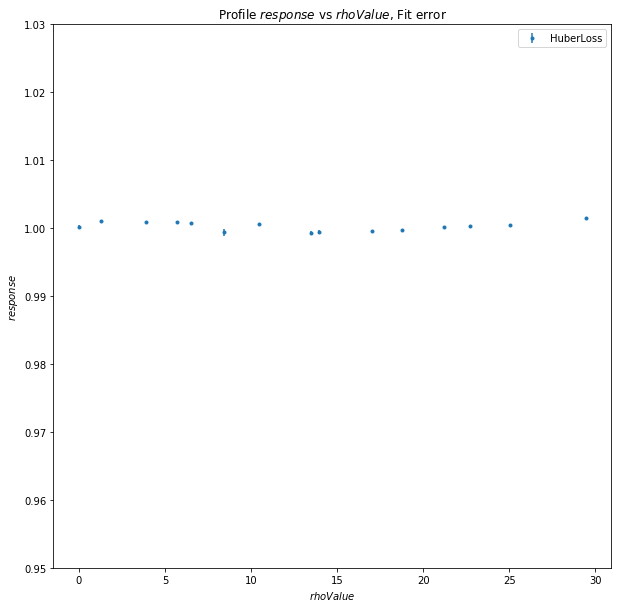

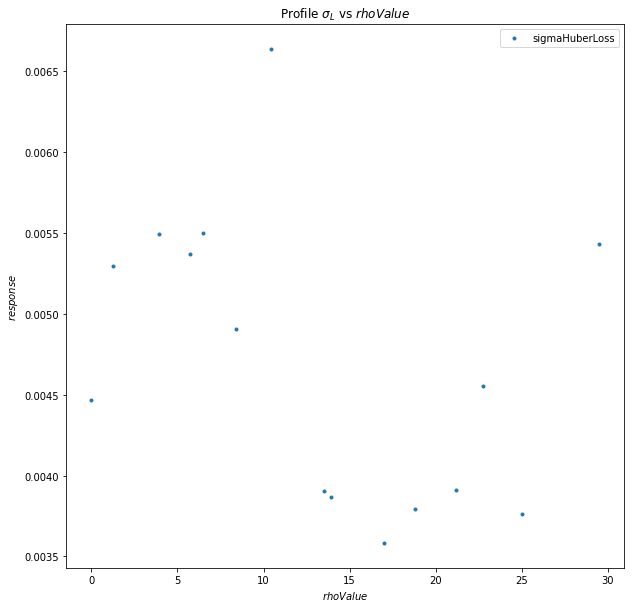

In [52]:

bins_gaussian_amount=100
bins_double_gaussian_amount=20
amountbins_column=15
end='HuberLoss'
lbl='delta4'
debug_fit=0
plot_out_dir="/t3home/kaechb/HuberLossApply2/"
debug_fit_gauss=0
for column in ['pt','scEta','rhoValue']:#

    profile_x=[]
    profile_y=[]
    profile_ef=[]
    profile_down=[]
    profile_up=[]
    profile_sigma_l=[]

    for k in range(0,len(names)):
        if k<len(names):
            inp_dir=parent_dir
            inp_file=names[k]
            if names[k].find("OneTail")>0:

                    end="HuberLossOneTail"
                    lbl="delta"+names[k][21]
                    color='r'
                    color2='y'
            elif names[k].find("Huber")>0:
                    end="HuberLoss"
                    lbl="delta"+names[k][14]
                    color='b'
                    color2='m'
        else:
            end="BDT"
            lbl="BDT"
        original_df=io.read_data('%s%s'%(inp_dir,inp_file),columns=None)
        print('%s%s'%(inp_dir,inp_file))

        lower_bound=0.9
        upper_bound=1.1

        y_plot=np.zeros(amountbins)
        x_plot=np.zeros(amountbins)
        y_err_fit=np.zeros(amountbins)
        sigma_l=np.zeros(amountbins)
        y_err_L_sigma=np.zeros(amountbins)
        y_err_R_sigma=np.zeros(amountbins)
        df=original_df.copy()

            
        df.loc[:,'response']=np.reciprocal(df.loc[:,'response'].values)
        df=df[df['response']>lower_bound]
        df=df[df['response']<upper_bound]
        if k<len(names):
            df.loc[:,'response_NN_'+end]=np.reciprocal(df.loc[:,'response_NN_'+end].values)
            df=df[df['response_NN_'+end]>lower_bound]
            df=df[df['response_NN_'+end]<upper_bound]
        df=df[df['pt']>0]
#        df.loc[:,column[:2]]=df[abs(df[column[:2]]-df[column[:2]].mean())<3*df[column[:2]].std()][column[:2]] #outlier fuck up binning otherwise
        notused,bins=pd.qcut(df[column],amountbins_column, retbins=True)   

        for i in range(0,len(bins)-1):
            try:
                ##selecting data in bin
                df_temp=df[df[column] >=bins[i]]

                df_temp=df_temp[df_temp[column]<=bins[i+1]]
                if k<len(names):
                    data=df_temp.loc[:,'response_NN_'+end].astype(float).values

                else:
                    data=df_temp.loc[:,'response'].astype(float).values 


                n,bins_gauss,patches=plt.hist(data,bins=bins_gaussian_amount,density=True)
                plt.close()
                if np.sum(n) ==0:
                    print("sum is zero!")
                    continue
                n_max=np.argmax(n)
                print("max n:{} at {}".format(np.max(n),bins_gauss[n_max]))
                bound_gauss=[bins_gauss[n_max-2],bins_gauss[n_max+3]]#centered around the max
                normalized_gaussian = probfit.Normalized(probfit.gaussian, bound_gauss)
                normalized_doublegaussian = probfit.Normalized(probfit.pdf.doublegaussian, bound_gauss)
                binned_likelihood_gauss = probfit.BinnedLH(normalized_gaussian, data, 
                                         bins=bins_double_gaussian_amount, bound=bound_gauss)

                pars_gauss = dict(mean  = bins_gauss[np.argmax(n)],
                                  sigma = 0.05,
                                   )
                minuit = iminuit.Minuit(binned_likelihood_gauss,print_level=debug_fit_gauss, **pars_gauss)
                minuit.migrad()  
                binned_likelihood_gauss.draw(minuit,nfbins=bins_double_gaussian_amount)
                plt.close()




                mean_gauss  = minuit.values[0]
                sigma_gauss = minuit.values[1]
                if sigma_gauss==0:
                    sigma_gauss==0.05
                pars_dg = dict(mean  = mean_gauss,  
                               sigma_L = sigma_gauss,
                               sigma_R =sigma_gauss,
                               limit_sigma_L=(0.001,0.1),
                               limit_sigma_R=(0.001,0.3),
                               )
                binned_likelihood_dg   = probfit.BinnedLH(normalized_doublegaussian, data,
                                bins=bins_double_gaussian_amount, bound=bound_gauss)

                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit, **pars_dg)
                minuit.migrad( ) 
                binned_likelihood_dg.draw(minuit)
                plt.close()

                pars =dict(minuit.values)

                #pars['limit_mean']=(0.986,1.01)
                minuit = iminuit.Minuit(binned_likelihood_dg,print_level=debug_fit_gauss, **pars)
                minuit.migrad()  
                coeff=minuit.args
                display(coeff)

                ax=plt.subplot2grid((6,3),(0,0), rowspan=4,colspan=4)   
                (data_edges, datay), (errorp, errorm), (total_pdf_x, total_pdf_y),parts = \
                binned_likelihood_dg.draw(minuit,parmloc=((0.1,0.95)),nfbins=10*bins_double_gaussian_amount)

                plt.title("Double Gaussian $response$ for ${}$ in {} to {}".format(column,int(10*bins[i])/10.,int(10*bins[i+1])/10.))
                data_edges=(data_edges[1:]+data_edges[:-1])/2
                fit_y=np.zeros(len(datay))
                x_plot[i]=df_temp[column].values[np.argmin(df_temp['response'].values-coeff[0])]
                y_plot[i]=coeff[0]
                y_err_fit[i]+=minuit.errors[0]
                y_err_L_sigma[i]+=coeff[1]
                sigma_l[i]+=coeff[1]
                y_err_R_sigma[i]+=coeff[2]
                for kill in range(0,len(datay)):
                    fit_y[kill]=total_pdf_y[np.argmin(abs(total_pdf_x - data_edges[kill]))]
                ratio=datay/fit_y
                plt.subplot2grid((5,3),(4,0),rowspan=2,colspan=4).set_yticks([0.8,1])
                plt.plot(data_edges,ratio,'bo')


                plt.ylabel(r"$ratio$")
                plt.xlabel("response")
                plt.ylim([0.8,1.2])
                plt.savefig("/scratch/kaechb/Comparision/old_{}__{}_{}_{}".format(column,i,end,lbl)) 

                plt.show()

            except Exception as e:
                print(traceback.print_exc())
                print ("erroor")
        
        profile_x.append(x_plot)
        profile_y.append(y_plot)
        profile_ef.append(y_err_fit)
        profile_down.append(y_err_L_sigma)
        profile_up.append(y_err_R_sigma)
        profile_sigma_l.append(sigma_l)



    fig,ax=plt.subplots()
    ax.set_ylim([0.95,1.03])
    ax.set_title("Profile $response$ vs ${}$, Fit error".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):
   
            if names[index].find("OneTail")>0:

                    end="HuberLossOneTail"
                    lbl="delta"+names[index][21]
                    end=end+lbl

            elif names[index].find("Huber")>0:
                    end="HuberLoss"
                    lbl="delta"+names[index][14]
                    end=end+lbl
            ax.errorbar(profile_x[index],profile_y[index],yerr=profile_ef[index],fmt='.',label=end)  
    ax.legend()
    fig.savefig(plot_out_dir+"Fit_Error_{}response_vs_{}".format(end,column))
    fig.show()
    
    fig,ax=plt.subplots()

    ax.set_title("Profile $\sigma_L$ vs ${}$".format(column))
    ax.set_ylabel(r"$response$")
    ax.set_xlabel(r"${}$".format(column))
    for index in range(0,len(names)):
#         if index==len(names)+1:
#             end="BDT"

#         else:
        if names[index].find("OneTail")>0:

                end="HuberLossOneTail"
                lbl="delta"+names[index][21]
                end=end+lbl

        elif names[index].find("Huber")>0:
                end="HuberLoss"
                lbl="delta"+names[index][14]
                end=end+lbl
        ax.errorbar(profile_x[index],profile_sigma_l[index],fmt='.',label="sigma"+end)  
    ax.legend()
    fig.savefig(plot_out_dir+"Sigma_L_{}response_vs_{}".format(end,column))
    fig.show()






In [12]:
df.columns

Index([u'response', u'resolution', u'scIsEB', u'genEnergy', u'scRawEnergy',
       u'scEtaWidth', u'scPhiWidth', u'full5x5_e5x5', u'hadronicOverEm',
       u'rhoValue', u'delEtaSeed', u'delPhiSeed', u'full5x5_sigmaIetaIeta',
       u'full5x5_sigmaIetaIphi', u'full5x5_sigmaIphiIphi', u'full5x5_eMax',
       u'full5x5_e2nd', u'full5x5_eTop', u'full5x5_eBottom', u'full5x5_eLeft',
       u'full5x5_eRight', u'full5x5_e2x5Max', u'full5x5_e2x5Left',
       u'full5x5_e2x5Right', u'full5x5_e2x5Top', u'full5x5_e2x5Bottom',
       u'N_SATURATEDXTALS', u'N_ECALClusters', u'clusterRawEnergy_0',
       u'clusterRawEnergy_1', u'clusterRawEnergy_2', u'clusterDPhiToSeed_0',
       u'clusterDPhiToSeed_1', u'clusterDPhiToSeed_2', u'clusterDEtaToSeed_0',
       u'clusterDEtaToSeed_1', u'clusterDEtaToSeed_2', u'iEtaMod5_int',
       u'iPhiMod2_int', u'iEtaMod20_int', u'iPhiMod20_int',
       u'iEtaCoordinate_int', u'iPhiCoordinate_int', u'scPreshowerEnergy',
       u'trkMomentumRelError', u'trkMomentum', u

In [ ]:
len(names)
